# Explore here

In [4]:
import pandas as pd
import random
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, DecisionTreeRegressor
from sklearn.metrics import *
from imblearn.metrics import specificity_score

In [5]:
datos_diabetes = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
datos_diabetes.shape

(768, 9)

In [6]:
datos_diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [7]:
datos_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
datos_diabetes.duplicated().sum()

0

In [9]:
datos_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


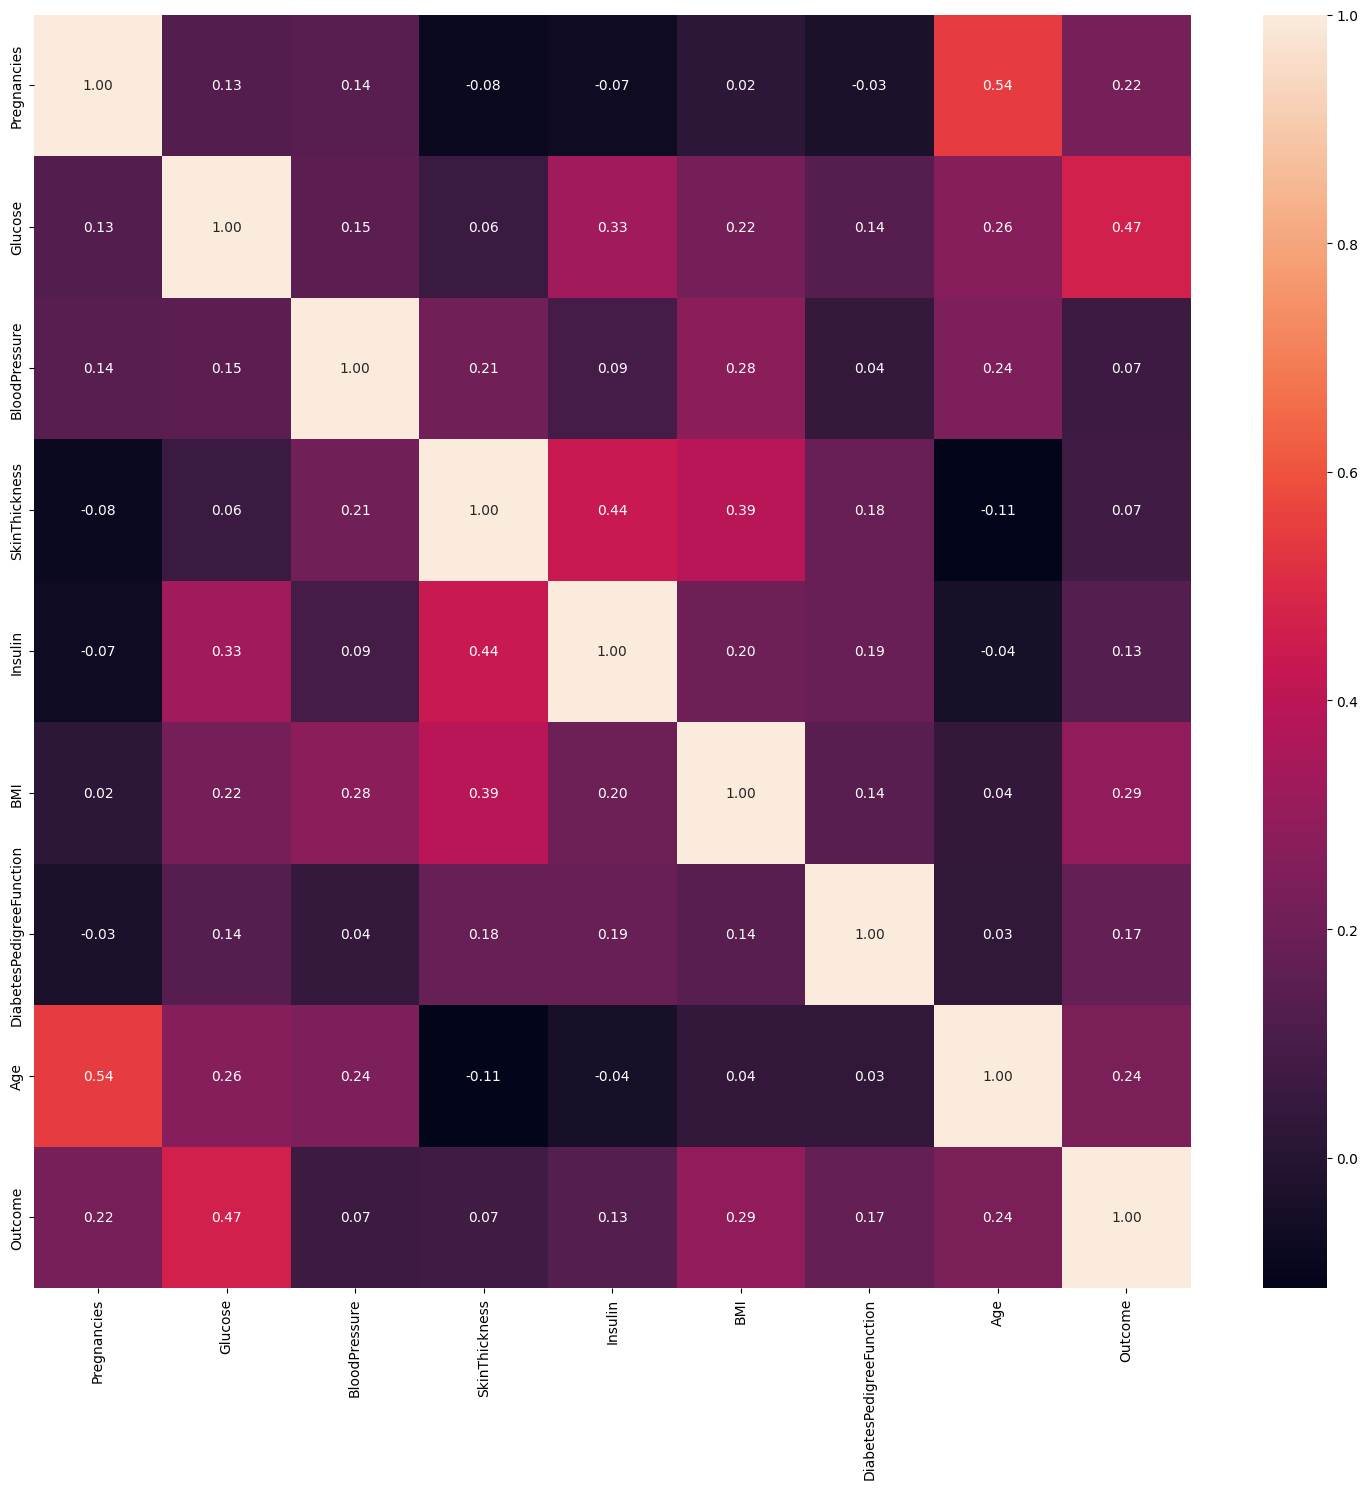

In [10]:
fig, axes = plt.subplots(figsize=(15, 15))

sns.heatmap(datos_diabetes[["Pregnancies","Glucose", "BloodPressure","SkinThickness","Insulin","BMI", "DiabetesPedigreeFunction", "Age","Outcome"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

In [11]:
datos_diabetes.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [12]:
X = datos_diabetes.drop("Outcome", axis = 1)
y = datos_diabetes["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(k = 7)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,84.0,0.0,0.0,0.0,0.304,21.0
1,9.0,112.0,82.0,0.0,28.2,1.282,50.0
2,1.0,139.0,46.0,83.0,28.7,0.654,22.0
3,0.0,161.0,50.0,0.0,21.9,0.254,65.0
4,6.0,134.0,80.0,370.0,46.2,0.238,46.0


In [13]:
X_test_sel.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,98.0,58.0,190.0,34.0,0.430,43.0
1,2.0,112.0,75.0,0.0,35.7,0.148,21.0
2,2.0,108.0,64.0,0.0,30.8,0.158,21.0
3,8.0,107.0,80.0,0.0,24.6,0.856,34.0
4,7.0,136.0,90.0,0.0,29.9,0.210,50.0


In [14]:
X_train_sel["Outcome"] = y_train.values
X_test_sel["Outcome"] = y_test.values
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [15]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

In [16]:
train_data.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.0,84.0,0.0,0.0,0.0,0.304,21.0,0
1,9.0,112.0,82.0,0.0,28.2,1.282,50.0,1
2,1.0,139.0,46.0,83.0,28.7,0.654,22.0,0
3,0.0,161.0,50.0,0.0,21.9,0.254,65.0,0
4,6.0,134.0,80.0,370.0,46.2,0.238,46.0,1


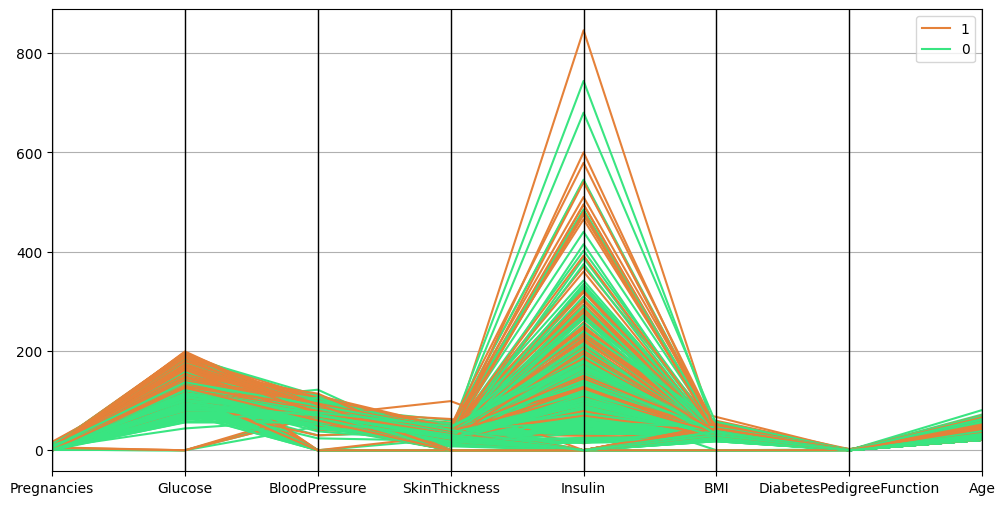

In [17]:
plt.figure(figsize=(12, 6))

pd.plotting.parallel_coordinates(datos_diabetes, "Outcome", color = ("#E58139", "#39E581", "#8139E5"))

plt.show()

In [18]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

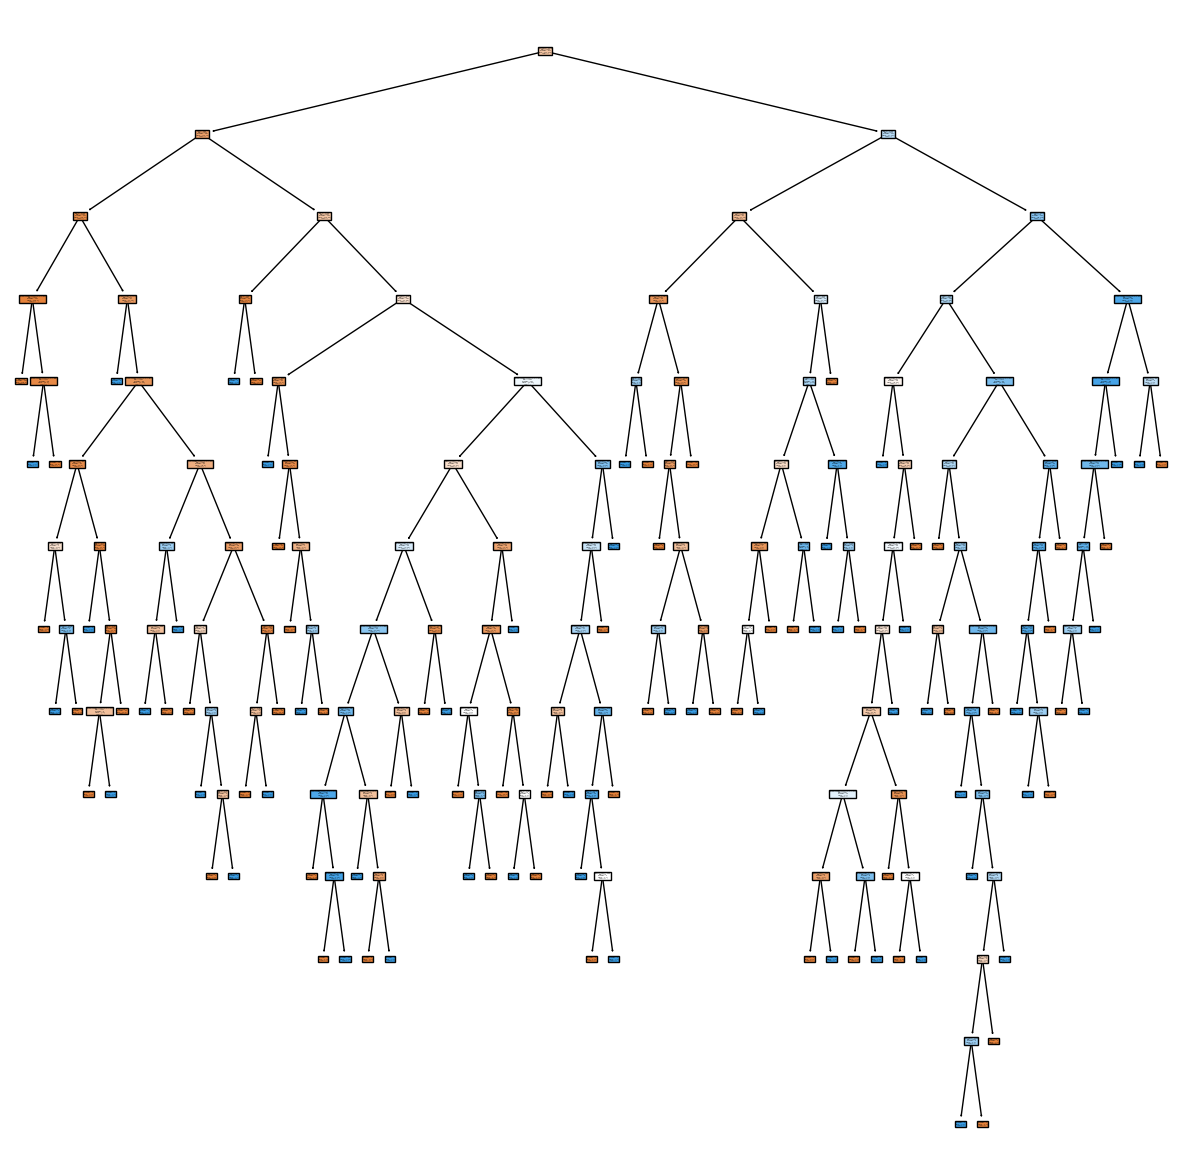

In [19]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()

In [20]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [21]:
accuracy_score(y_test, y_pred)

0.7467532467532467

In [22]:
# Crear un árbol de decisión complejo
complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train, y_train)

# Crear un árbol de decisión simple
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, random_state=42)
simple_tree.fit(X_train, y_train)

# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

In [23]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [24]:
# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000,1.000000,1.000000
Test,0.746753,0.672269,0.742424,0.625,0.727273,0.757576
Diferencia,0.253247,0.327731,0.257576,0.375,0.272727,0.242424


In [25]:
# Métricas del modelo simple
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.737785,0.663883,0.739823,0.597744,0.746479,0.733167
Test,0.636364,0.594203,0.660606,0.493976,0.745455,0.575758
Diferencia,0.101421,0.069680,0.079217,0.103768,0.001024,0.157410


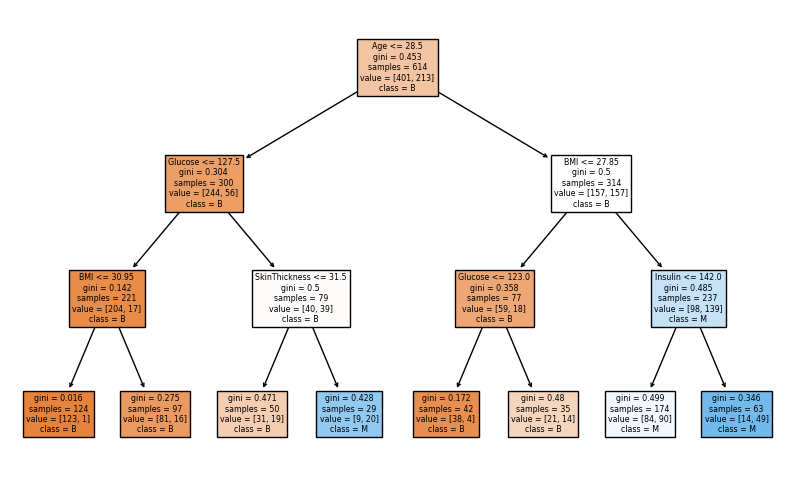

In [26]:
# Visualiza el árbol de decisión gráficamente
plt.figure(figsize=(10, 6))
plot_tree(simple_tree, feature_names=X_train.columns, class_names=['B','M'], filled=True)
plt.show()

In [27]:
hyperparams = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4, 6, 8]
}

grid = GridSearchCV(model, hyperparams, scoring = "precision", cv = 10)
grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10, 20, 30, 50],
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             scoring='precision')

In [28]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [29]:
model = grid.best_estimator_

In [30]:
precision_score(y_test, y_pred)

0.625

In [31]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [32]:
# Realizamos predicciones en el conjunto de entrenamiento y prueba
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.776873,0.658354,0.740034,0.702128,0.619718,0.860349
Test,0.759740,0.647619,0.728283,0.680000,0.618182,0.838384
Diferencia,0.017133,0.010735,0.011751,0.022128,0.001536,0.021965
